## About
This notebook generates the phosphorylation analysis. 

## Figures
This notebook generates panels for **Fig. 3K.** and **Fig. S8**. Note **3K** is *right* at the end of this notebook...



In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from sparrow import Protein
import protfasta

from finches import Mpipi_frontend, CALVADOS_frontend
from tqdm.auto import tqdm
import math

In [2]:
import metapredict as meta
from shephard.apis import uniprot
from shephard.interfaces import si_domains, si_protein_attributes, si_sites

In [3]:
def round_to_sig_figs(num, sig_figs):
    if num == 0:
        return 0  # handle zero case
        
    # Calculate the order of magnitude of the number
    order_of_magnitude = int(math.floor(math.log10(abs(num))))
    
    # Calculate the factor to multiply so that the round function can be applied correctly
    factor = 10**(sig_figs - order_of_magnitude - 1)
    
    # Round the number and then divide it back to the original scale
    return round(num * factor) / factor

In [4]:
# NOTE this selector defines the mode with which we run this analysis. Must be one of
# mpipi or calvados
mode = 'mpipi'

# read in annotated IDR domains
if mode == 'mpipi':
    Xf = Mpipi_frontend()    
elif mode == 'calvados':    
    Xf = CALVADOS_frontend()
else:
    raise Exception('mode must be mpipi or calvados')


In [6]:
# read in human proteome (this will be the unphosphorylated version)
HP = uniprot.uniprot_fasta_to_proteome('../../data/human_proteome_clean.fasta')

# read in human proteome and then annotate with phosphosites
HP_phos = uniprot.uniprot_fasta_to_proteome('../../data/human_proteome_clean.fasta')
si_sites.add_sites_from_file(HP_phos, '../../data/shprd_sites_ptms.tsv', safe=False, verbose=False)

#
# Perform proteome-scale phosphomimetic subsitution
#
c_t = 0
c_s = 0
c_y = 0

# for each protein in the phosphorylated human proteome
for p in tqdm(HP_phos):

    # for each site in this protein
    for s in p.sites:

        # check if a specific type of site is defined the underlying AA ACTUALLY matches what
        # makes sense here (and count this)
        if s.site_type == 'Phosphothreonine':            
            if p.get_sequence_region(s.position, s.position)  == 'T':

                # get the amino acid sequence associated with this protein
                tmp = list(p._sequence)

                # set the position of this phosphosite to a glutamic acid (E)
                tmp[s.position] = 'E'

                # re-assign the sequence associated with this protein to the phoshomimetic 
                # version of the sequence (note this will sequentially update so previous
                # phosphomimetics are propagated)
                p._sequence = "".join(tmp)

                # increment count for phosphothreonine
                c_t = c_t +1 

        # we do the same pattern as described for phosphothreonine for pSer and pTyr
        elif s.site_type == 'Phosphoserine':
            if p.get_sequence_region(s.position, s.position)  == 'S':
                tmp = list(p._sequence)
                tmp[s.position] = 'E'
                p._sequence = "".join(tmp)
                c_s = c_s + 1
            
        elif s.site_type == 'Phosphotyrosine':
            if p.get_sequence_region(s.position, s.position)  == 'Y':
                tmp = list(p._sequence)
                tmp[s.position] = 'E'
                p._sequence = "".join(tmp)
                c_y = c_y + 1

print(f"We found {c_t} phospho-threonine sites")
print(f"We found {c_s} phospho-serine sites")
print(f"We found {c_y} phospho-tyrosine sites")

  0%|          | 0/20434 [00:00<?, ?it/s]

We found 53744 phospho-threonine sites
We found 130606 phospho-serine sites
We found 38106 phospho-tyrosine sites


### Annotate with homotypic epsilon for phosphorylated IDRs
The cell below will annotate each IDR in the "phosphorylated human proteome (`HP_phos`) - i.e. IDRs where every phosphosite has been converted from S/T/Y to E – with the homotypic epsilon for that IDR sequence. 

In [7]:
# recompute epsilon after phosphomimetic? If RECOMPUTE=False we will (try) to read from a previously computed annotation. This
# is obviously the recommended approach because we have already computed what the per-IDR homotypic epsilon should be after 
# phosphomimetic mutations, but we retain the ability to do this from scratch if someone wanted to re-run this analysis from
# the ground up

RECOMPUTE = False
WRITE = False

# if RECOMPUT = True then the code below will
# (1) Annotate the HP_phos proteome object with all IDRs
# (2) Then for each IDR, recompute the epsilon value USING the phosphomimetic subsitutions made
#     in the preceding cell

# if WRITE and RECOMPUTE are set to true, then the IDRs with phopshomimetic changes and epsilons
# calculated are written as a SHEPHARD domains file.
if RECOMPUTE:
    
    # load the empty domains...
    si_domains.add_domains_from_file(HP_phos, '../../data/shprd_idrs_domain.tsv')
    
    for d in tqdm(HP_phos.domains):
        d.add_attribute('eps', round_to_sig_figs(Xf.epsilon(d.sequence, d.sequence),3), safe=False)
    if WRITE:
        si_domains.write_domains(HP_phos,    f'../../data/shprd_IDR_domains_with_eps_phosphor_{mode}.tsv')
else:
    si_domains.add_domains_from_file(HP_phos,f'../../data/shprd_IDR_domains_with_eps_phosphor_{mode}.tsv', safe=False)



### Annotate with homotypic epsilon for unphosphorylated IDRs
The cell below will annotate each IDR in the "unphosphorylated human proteome" (`HP`) with the homotypic epsilon for that IDR sequence. 

In [8]:
# Annotate the UNPHOSPHORYLATED proteome
if mode == 'mpipi':
    si_domains.add_domains_from_file(HP, '../../data/shprd_IDR_domains_with_atts_tc_eps.tsv')
elif mode == 'calvados':
    si_domains.add_domains_from_file(HP, '../../data/shprd_IDR_domains_with_atts_tc_eps_CALVADOS.tsv')
else:
    raise Exception('mode must be mpipi or calvados')

# cast floats 
for d in HP_phos.domains:
    d.add_attribute('eps', float(d.attribute('eps')), safe=False)

for d in HP.domains:    
    d.add_attribute('eps', float(d.attribute('eps')), safe=False)
    
    

## Write out TABLES for future analysis
The three cells below are designed to provide data for future investigation.

The first file – `PHOS_all_idrs_homotypic_eps_<mode>.csv` – takes ALL IDRs with one or more phosphosite and reports all the info needed for further analysis.

The second file – `PHOS_all_gain_of_eps_{mode}.csv` – reports ONLY those sequences where the phosphorylated version has an attractive epsilon (i.e. eps < 0) and the change in epsilon upon phosphorylation is to make epsilon more attractive (i.e. more negative). These are proteins which in principle should become (more) prone to homotypic phase separation upon phosphorylation.

The third file – `PHOS_all_loss_of_eps_{mode}.csv` – reports ONLY those sequences where prior to phosophorylation epsilon is negative (attractive) and post phosphorylation epsilon is now positive (repuslive). Note this is NOT exactly the inverse of the second file, because the second file is asking "does homotypic become stronger EVEN if prior to phosphorylation epsilon was less the 0" whereas this file is asking "was the IDR attractive BEFORE phosphorylation but then repulsive after phosphorylation". In any case, this third file has proteins which in principle should be capable of phase separation prior to phosphorylation but then LOOSE that ability upon phosphorylation.



In [9]:
#
# This first file - PHOS_all_idrs_homotypic_eps_{mode}.csv
#

outlines = []
for p in HP.proteins:
    phos = HP_phos.protein(p)
    no_phos = HP.protein(p)        
    for d_phos, d in zip(phos.domains, no_phos.domains):
        if len(d_phos.sites) > 0:
            safename = d.protein.name.replace(',',';')
            diff = d.attribute('eps') - d_phos.attribute('eps')
            outlines.append([diff, f"{d.protein.unique_ID}, {safename}, {d.start}, {d.end}, {len(d)}, {len(d_phos.sites)}, {diff}, {d.attribute('eps')}, {d_phos.attribute('eps')}, {d.sequence}, {d_phos.sequence}\n"])
            
outlines_sorted = sorted(outlines, key=lambda x: x[0],reverse=True)

with open(f'../../data/outdata/proteome_wide_condensate/PHOS_all_idrs_homotypic_eps_{mode}.csv','w') as fh:
    fh.write(f"UniProt ID, name, IDR start, IDR end, IDR len, number of psites, pre-post, epsilon_pre, epsilon_post, sequence_pre, sequence_post\n")
    for line in outlines_sorted:
        fh.write(line[1])


In [10]:
GOF_domains = []
outlines = []
for p in HP.proteins:
    phos = HP_phos.protein(p)
    no_phos = HP.protein(p)        
    for d_phos, d in zip(phos.domains, no_phos.domains):
        if len(d_phos.sites) > 0:
            if d_phos.attribute('eps') < 0 and d_phos.attribute('eps') < d.attribute('eps'):
                safename = d.protein.name.replace(',',';')
                diff = d.attribute('eps') - d_phos.attribute('eps')
                outlines.append([diff, f"{d.protein.unique_ID}, {safename}, {d.start}, {d.end}, {len(d)}, {len(d_phos.sites)}, {diff}, {d.attribute('eps')}, {d_phos.attribute('eps')}, {d.sequence}, {d_phos.sequence}\n"])
                GOF_domains.append([d, d_phos])

outlines_sorted = sorted(outlines, key=lambda x: x[0],reverse=True)

with open(f'../../data/outdata/proteome_wide_condensate/PHOS_all_gain_of_eps_{mode}.csv','w') as fh:
    fh.write(f"UniProt ID, name, IDR start, IDR end, IDR len, number of psites, pre-post, epsilon_pre, epsilon_post, sequence_pre, sequence_post\n")
    for line in outlines_sorted:
        fh.write(line[1])

        

In [11]:
LOF_domains = []
outlines = []
for p in HP.proteins:
    phos = HP_phos.protein(p)
    no_phos = HP.protein(p)
    
    for d_phos, d in zip(phos.domains, no_phos.domains):
        if len(d_phos.sites) > 0:
            if d.attribute('eps') < 0 and d_phos.attribute('eps') >0:
                safename = d.protein.name.replace(',',';')
                diff = d.attribute('eps') - d_phos.attribute('eps')
                outlines.append([diff, f"{d.protein.unique_ID}, {safename}, {d.start}, {d.end}, {len(d)}, {len(d_phos.sites)}, {diff}, {d.attribute('eps')}, {d_phos.attribute('eps')}, {d.sequence}, {d_phos.sequence}\n"])
                LOF_domains.append([d, d_phos])

outlines_sorted = sorted(outlines, key=lambda x: x[0])

with open(f'../../data/outdata/proteome_wide_condensate/PHOS_all_loss_of_eps_{mode}.csv','w') as fh:
    fh.write(f"UniProt ID, name, IDR start, IDR end, IDR len, number of psites, pre-post, epsilon_pre, epsilon_post, sequence_pre, sequence_post\n")
    for line in outlines_sorted:
        fh.write(line[1])
        

## Plot example proteins 
The two cells below plot examples for intermaps where phosphorylation either ENHANCES homotypic interaction (GOF_domains) or reduces homotypic interaction (LOF_domains).

In [12]:
SKIP_INTERMAPS = True

if SKIP_INTERMAPS is False:
    for k in GOF_domains:
        if k[1].attribute('eps') - k[0].attribute('eps') < -1.5 and len(k[1].sites) > 5 and len(k[0]) > 80 and len(k[0]) < 250:
    
            print(k[1].protein.name)
            uid = k[1].protein.unique_ID
            start = k[1].start
            end = k[1].end
            
            IO = Xf.interaction_figure(k[0].sequence, k[0].sequence, fname=f'phosphorylation_examples_GOF/{mode}_{uid}_unphos_{start}_{end}.pdf',zero_folded=False)
            plt.close(IO[0])
            IO = Xf.interaction_figure(k[1].sequence, k[1].sequence, fname=f'phosphorylation_examples_GOF/{mode}_{uid}_phos_{start}_{end}.pdf', zero_folded=False)
            plt.close(IO[0])


In [13]:
if SKIP_INTERMAPS is False:
    for k in LOF_domains:
        if k[1].attribute('eps') - k[0].attribute('eps') > 8 and len(k[1].sites) > 5 and len(k[0]) > 80 and len(k[0]) < 250:
    
            print(k[1].protein.name)
            uid = k[1].protein.unique_ID
            start = k[1].start
            end = k[1].end
            IO = Xf.interaction_figure(k[0].sequence, k[0].sequence, fname=f'phosphorylation_examples_LOF/{mode}_{uid}_unphos_{start}_{end}.pdf',zero_folded=False)
            plt.close(IO[0])
            IO = Xf.interaction_figure(k[1].sequence, k[1].sequence, fname=f'phosphorylation_examples_LOF/{mode}_{uid}_phos_{start}_{end}.pdf', zero_folded=False,)
            plt.close(IO[0])
            

## Example case ZO1
The cell below plots a disordered prediction and annotates on phosphosites for ZO1 (Zonula Occludens).

In [14]:
for k in LOF_domains:
    if k[0].protein.unique_ID == 'Q07157':        
        print(k[0].sequence)
        print(k[1].sequence)


VWVSEGKADGATSDDLDLHDDRLSYLSAPGSEYSMYSTDSRHTSDYEDTDTEGGAYTDQELDETLNDEVGTPPESAITRSSEPVREDSSGMHHENQTYPPYSPQAQPQPIHRIDSPGFKPASQQKAEASSPVPYLSPETNPASSTSAVNHNVNLTNVRLEEPTPAPSTSYSPQADSLRTPSTEAAHIMLRDQEPSLSSHVDPTKVYRKDPYPEEMMRQNHVLKQPAVSHPGHRPDKEPNLTYEPQLPYVEKQASRDLEQPTYRYESSSYTDQFSRNYEHRLRYEDRVPMYEEQWSYYDDKQPYPSRPPFDNQHSQDLDSRQHPEESSERGYFPRFEEPAPLSYDSRPRYEQAPRASALRHEEQPAPGYDTHGRLRPEAQPHPSAGPKPAESKQYFEQYSRSYEQVPPQGFTSRAGHFEPLHGAAAVPPLIPSSQHKPEALPSNTKPLPPPPTQTEEEEDPAMKPQSVLTRVKMFENKRSASLETKKDVNDTGSFKPPEVASKPSGAPIIGPKPTSQNQFSEHDKTLYRIPEPQKPQLKPPEDIVRSNHYDPEEDEEYYRKQLSYFDRRSFENKPPAHIAASHLSEPAKPAHSQNQSNFSSYSSKGKPPEADGVDRSFGEKRYEPIQATPPPPPLPSQYAQPSQPVTSASLHIHSKGAHGEGNSVSLDFQNSLVSKPDPPPSQNKPATFRPPNREDTAQAAFYPQKSFPDKAPVNGTEQTQKTVTPAYNRFTPKPYTSSARPFERKFESPKFNHNLLPSETAHKPDLSSKTPTSPKTLVKSHSLAQPPEFDSGVETFSIHAEKPKYQINNISTVPKAIPVSPSAVEEDEDEDGHTVVATARGIFNSNGGVLSSI
VWVSEGKADGAEEDDLDLHDDRLEELEAPGEEEEMEETDERHEEDEEDEDEEGGAEEDQELDEELNDEVGEPPESAITRESEPVREDEEGMHHENQEEPPEEPQAQPQPIHRIDEPGFKPAEQQKAEAEEPVPELEPEENPASSTS

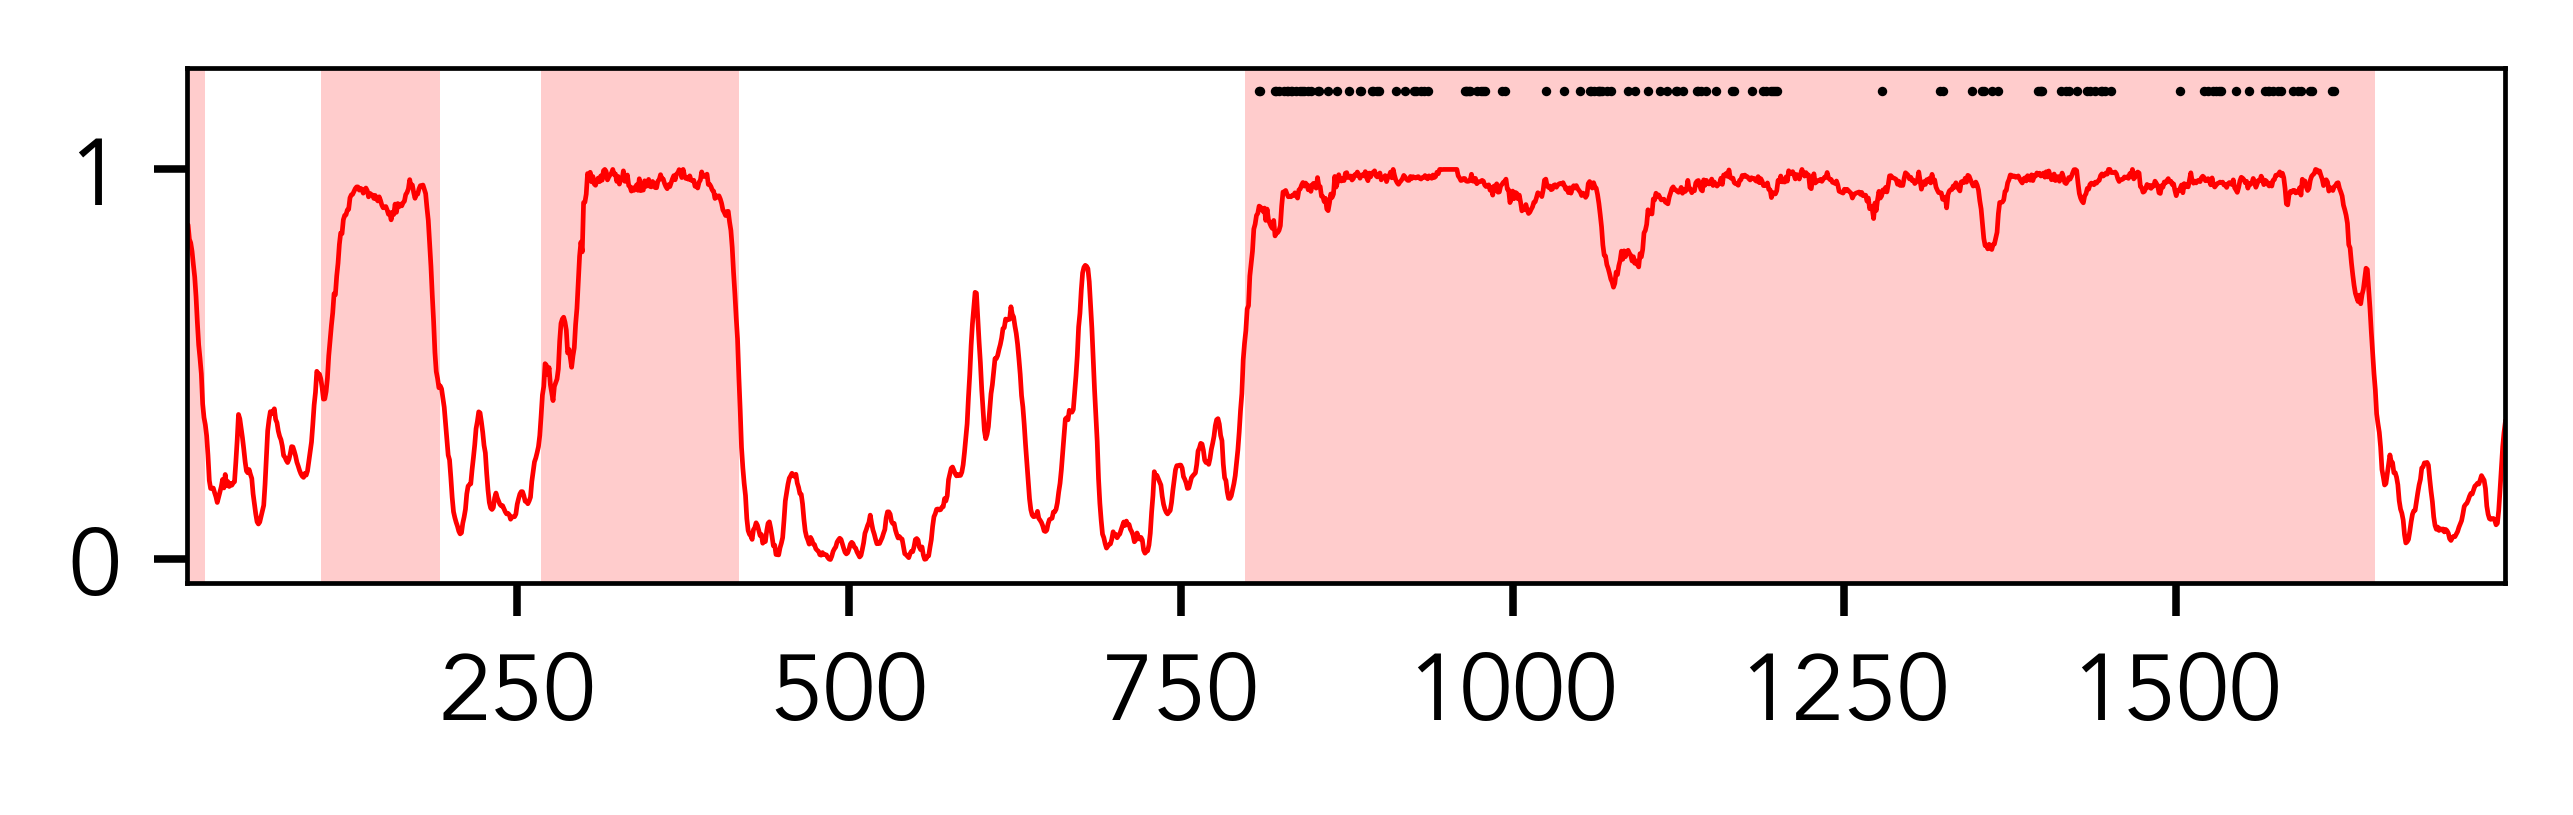

In [16]:
p = HP_phos.protein('Q07157')
idx = np.arange(1,len(p.sequence)+1)
ZO_disorder = meta.predict_disorder(p.sequence, version=2)

figure(None, (4,1.3), dpi=340)
ax = plt.gca()
plt.plot(idx,ZO_disorder, color='r', lw=0.5)
for d in p.domains:
    ax.axvspan(d.start,d.end, lw=0, alpha=0.2, color='r')

for s in p.domains[-1].sites:    
    plt.plot(s.position, 1.2, '.k',mew=0, ms=2)
    
plt.xlim([1, idx[-1]])
plt.tight_layout()
plt.savefig('out_figures/ZO1_disorder.pdf')

for k in LOF_domains:
    if k[0].protein.unique_ID == 'Q07157':        
        uid = k[1].protein.unique_ID
        start = k[1].start
        end = k[1].end
        IO = Xf.interaction_figure(k[0].sequence, k[0].sequence, fname=f'phosphorylation_examples_LOF/{mode}_ZO1_unphos_{start}_{end}.pdf',zero_folded=False)
        plt.close(IO[0])
        IO = Xf.interaction_figure(k[1].sequence, k[1].sequence, fname=f'phosphorylation_examples_LOF/{mode}_ZO1_phos_{start}_{end}.pdf', zero_folded=False,)
        plt.close(IO[0])



## Assemble data for proteome-wide figure
Finally, we assemble the data looking at how overall $\epsilon$ changes upon phosphorylation for plotting as a main text figure

In [17]:
pre = []
post = []
diffs = []
for p in HP.proteins:
    phos = HP_phos.protein(p)
    no_phos = HP.protein(p)
    for d_phos, d in zip(phos.domains, no_phos.domains):
        if len(d_phos.sites) > 0:
        
            diffs.append(d_phos.attribute('eps') - d.attribute('eps'))
            pre.append(d.attribute('eps'))
            post.append(d_phos.attribute('eps'))

diffs_sorted = sorted(diffs)

# thereshold for for what "no change" is - i.e. if phosphorylation has +/- effect
# of $thresh we consider this to be unchanged upon phosphorylation
thresh = 0.05

# find indices for thresholds
idx1 = np.sum(np.array(diffs_sorted)<-thresh)
idx2 = len(diffs_sorted) - np.sum(np.array(diffs_sorted)>thresh)

100.00999999999999
Percentage that increase eps: 29.44%
Percentage that have no impact on eps: 13.85%
Percentage that decrease eps: 56.72%


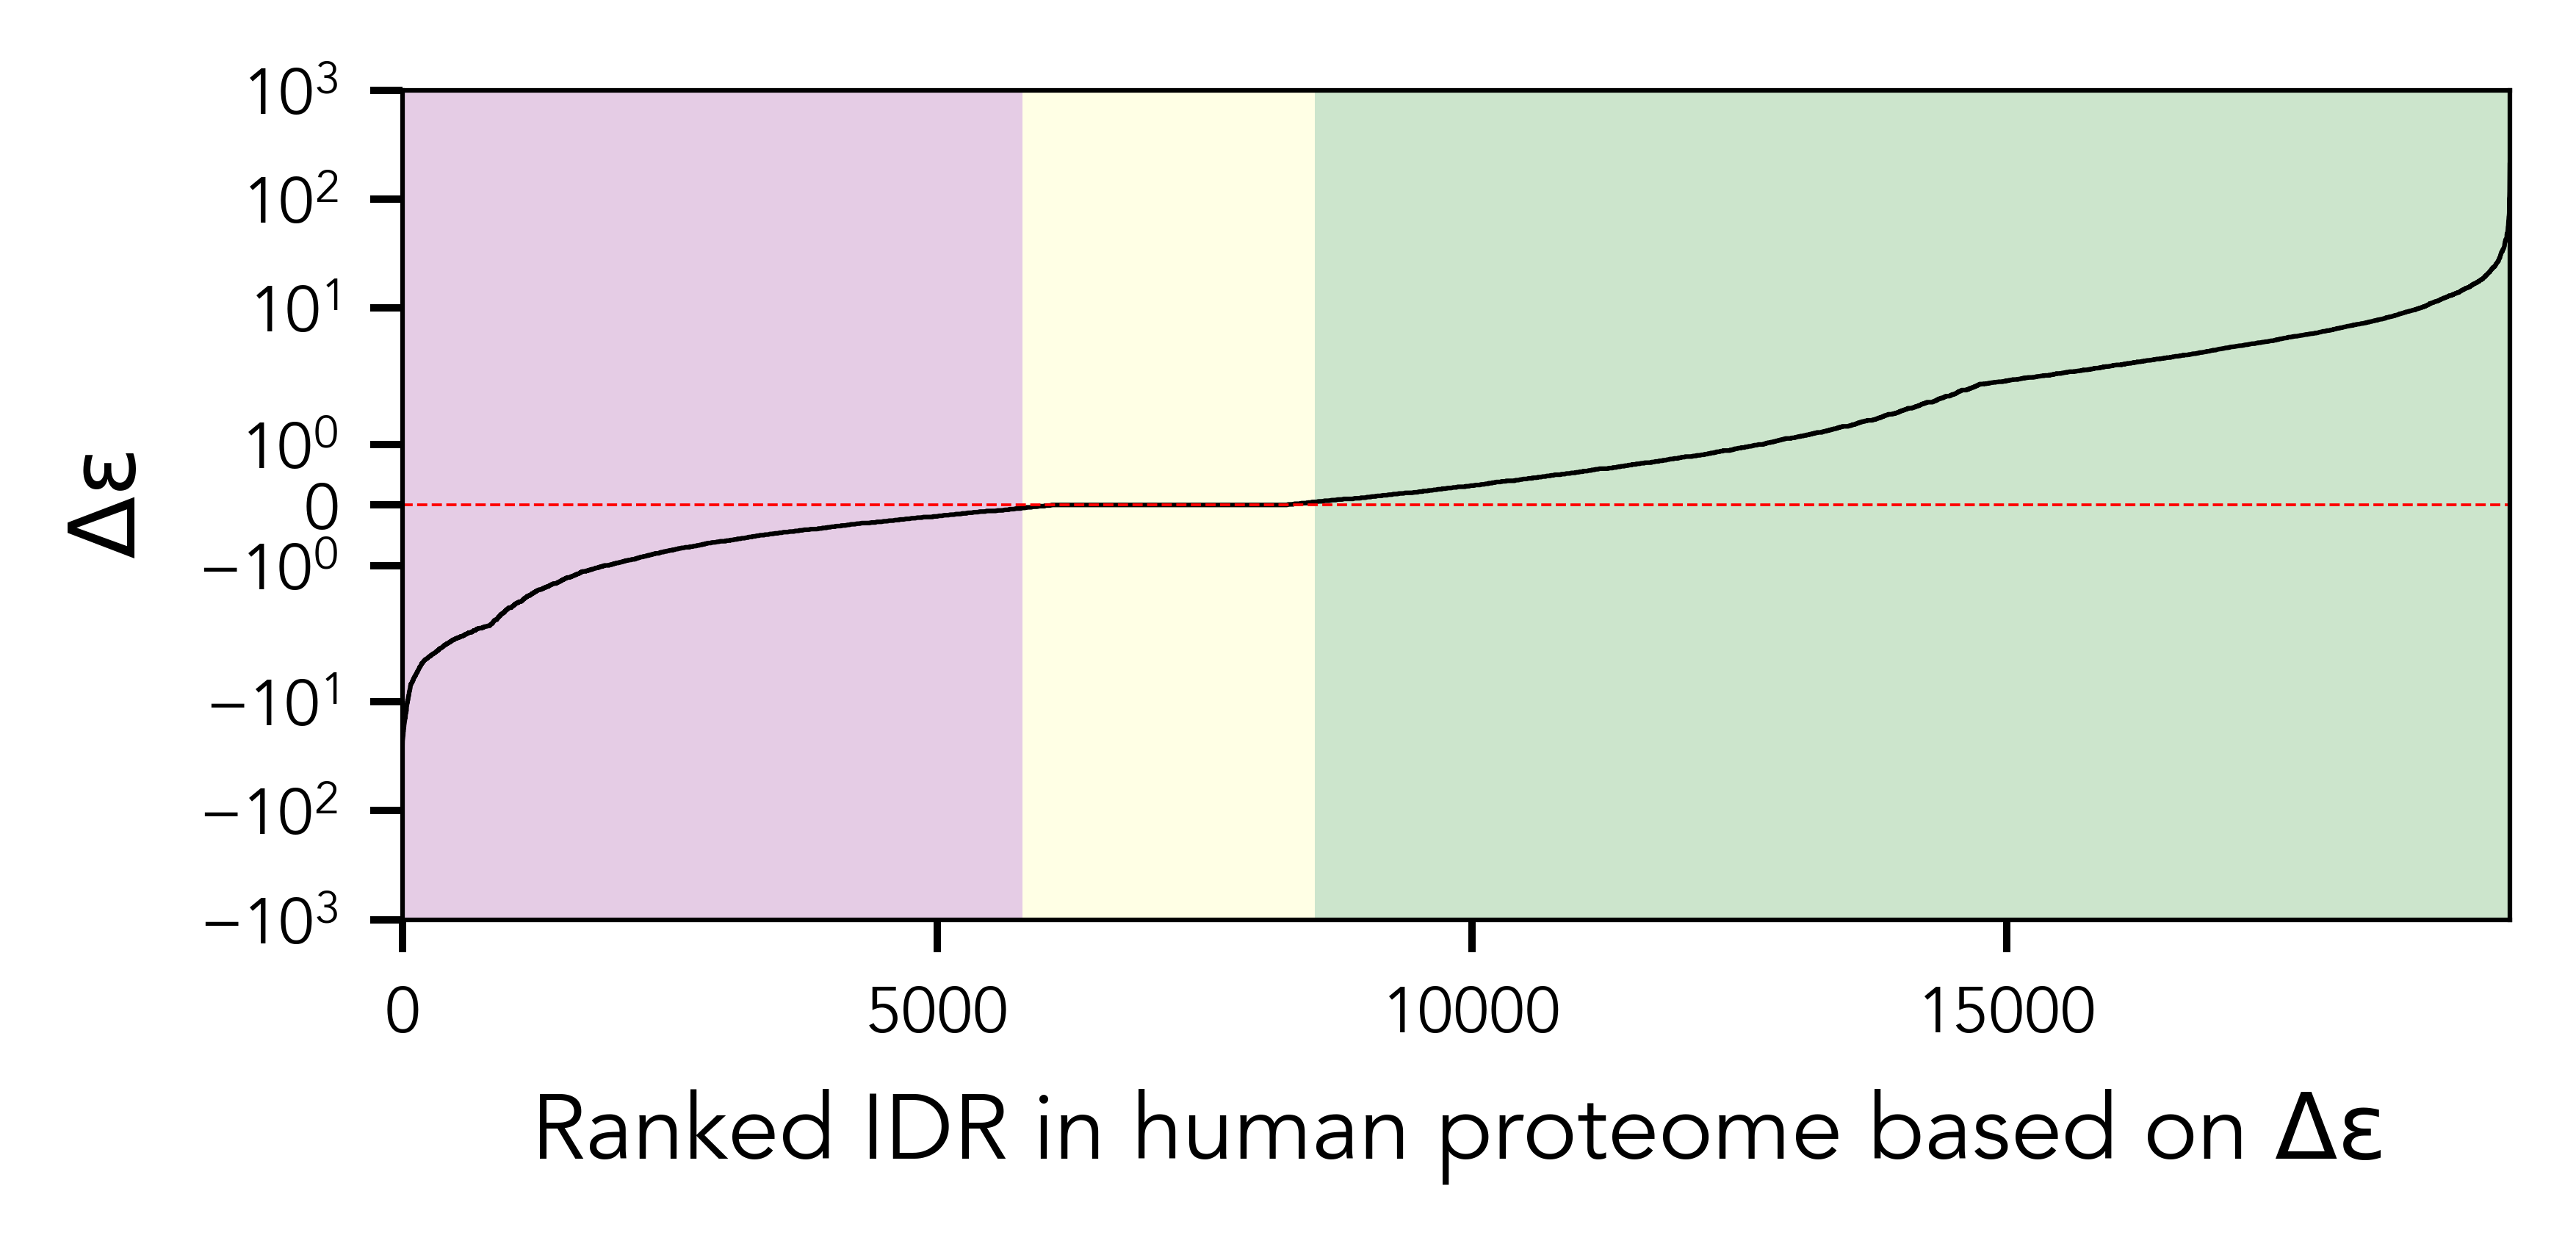

In [18]:
fig = plt.figure(figsize=(4, 2), dpi=450)
ax = plt.gca()

plt.plot(diffs_sorted, color='k',lw=0.5)
plt.ylim([-1000,1000])
plt.yscale('symlog')

ax.axvspan(0, idx1, color='purple', alpha=0.2,lw=0)
ax.axvspan(idx1, idx2, color='yellow', alpha=0.1,lw=0)
ax.axvspan(idx2, len(diffs_sorted), color='green', alpha=0.2,lw=0)

p1 = np.round(100*idx1/len(diffs_sorted),2)
p2 = np.round(100*(idx2-idx1)/len(diffs_sorted),2)
p3 = np.round(100*(len(diffs_sorted)-idx2)/len(diffs_sorted),2)
print(p1+p2+p3)
print(f"Percentage that increase eps: {p1}%")
print(f"Percentage that have no impact on eps: {p2}%")
print(f"Percentage that decrease eps: {p3}%")

ax.axhline(0,lw=0.3,color='r',ls='--')
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
plt.ylabel(r'$\rm \Delta \epsilon$')
plt.xlabel(r'Ranked IDR in human proteome based on $\rm \Delta \epsilon$')

plt.xlim([0,len(diffs_sorted)])
plt.tight_layout()

plt.savefig(f'out_figures/phosphoimpact_{mode}.pdf')